In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargamos el dataset de actividad de usuarios
df = pd.read_csv("../data/raw/user_activity.csv")

# Vista rápida de los datos
df.head()

,user_id,signup_date,plan_type,sessions_last_7d,sessions_last_30d,avg_session_time,tickets_opened,payments_failed,days_since_last_activity,churned
0,1,2025-08-06 20:43:38.078863,pro,14,19,589.257975,0,0,3,0
1,2,2025-01-27 20:43:38.078863,free,11,11,187.081533,0,0,15,0
2,3,2025-09-27 20:43:38.078863,free,0,9,219.974615,0,0,44,1
3,4,2025-02-26 20:43:38.078863,free,4,15,374.743982,0,0,5,0
4,5,2025-05-10 20:43:38.078863,pro,0,17,624.585954,2,0,46,1


In [3]:
# Porcentaje de usuarios que churnean vs los que no
df["churned"].value_counts(normalize=True) * 100

churned
0    72.7
1    27.3
Name: proportion, dtype: float64

Este cálculo nos permite entender el balance general del dataset
y verificar que no esté completamente desbalanceado.

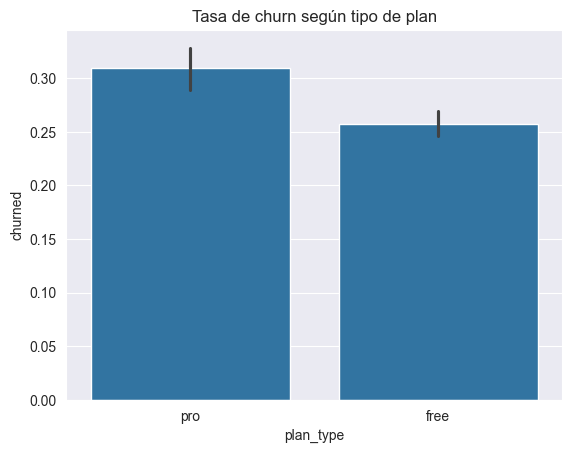

In [4]:
sns.barplot(
    data=df,
    x="plan_type",
    y="churned"
)
plt.title("Tasa de churn según tipo de plan")
plt.show()

**Pregunta:**
¿El tipo de plan influye en la probabilidad de churn?

**Observación:**
Los usuarios con plan Pro presentan una tasa de churn más alta de lo esperado.

**Nota:**
Esto es contraintuitivo, ya que son usuarios pagos.
Puede indicar problemas de expectativas, valor percibido o pricing.


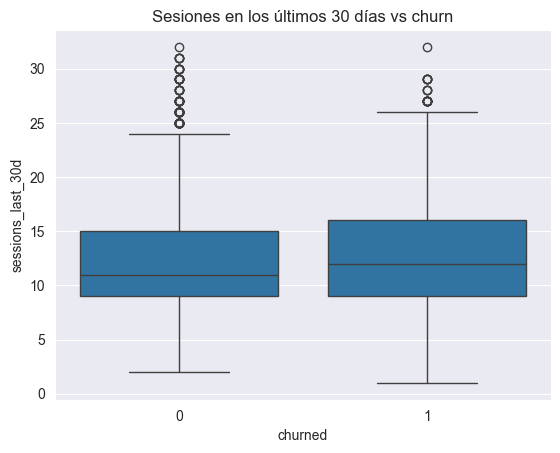

In [5]:
sns.boxplot(
    data=df,
    x="churned",
    y="sessions_last_30d"
)
plt.title("Sesiones en los últimos 30 días vs churn")
plt.show()

**Pregunta:**
¿Los usuarios que churnean usan menos la plataforma?

**Observación:**
No se observa una diferencia clara entre ambos grupos.

**Conclusión parcial:**
La cantidad total de sesiones no parece explicar el churn.


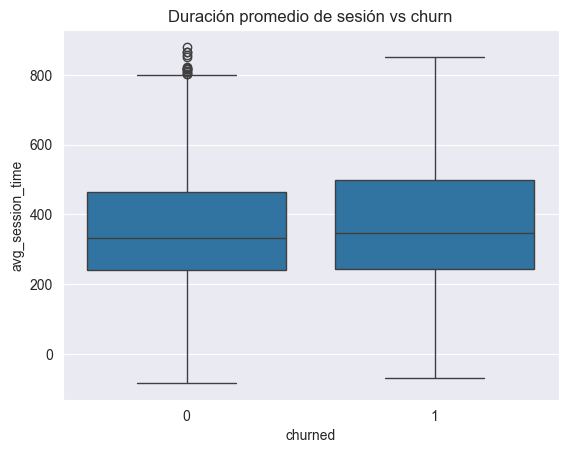

In [6]:
sns.boxplot(
    data=df,
    x="churned",
    y="avg_session_time"
)
plt.title("Duración promedio de sesión vs churn")
plt.show()

**Pregunta:**
¿Los usuarios que churnean tienen sesiones más cortas?

**Observación:**
Las distribuciones son muy similares.

**Conclusión parcial:**
La duración de uso tampoco es un indicador fuerte de churn.


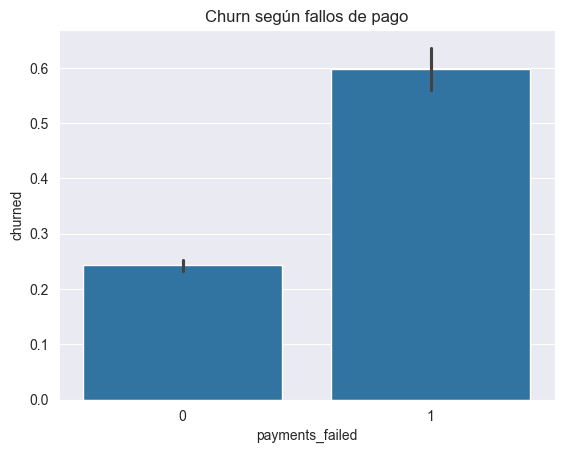

In [7]:
sns.barplot(
    data=df,
    x="payments_failed",
    y="churned"
)
plt.title("Churn según fallos de pago")
plt.show()

**Pregunta:**
¿Los problemas de pago están relacionados con el churn?

**Observación:**
Los usuarios con pagos fallidos tienen mayor probabilidad de churn.

**Interpretación:**
Parte del churn puede estar explicado por razones económicas
y no por desuso de la plataforma.

In [8]:
# Creamos una métrica de actividad reciente
df["activity_ratio"] = df["sessions_last_7d"] / (df["sessions_last_30d"] + 1)

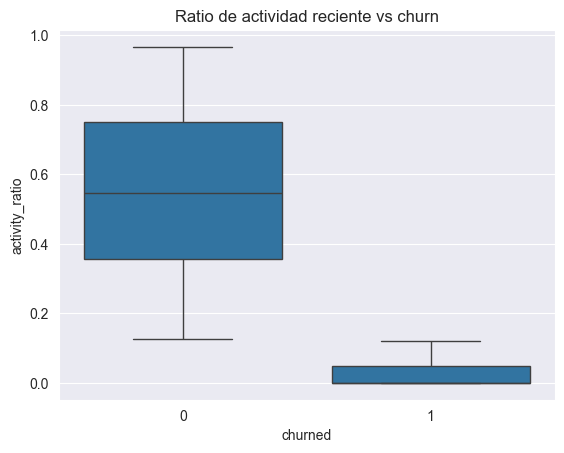

In [9]:
sns.boxplot(
    data=df,
    x="churned",
    y="activity_ratio"
)
plt.title("Ratio de actividad reciente vs churn")
plt.show()

**Pregunta:**
¿Existe una caída reciente de actividad en los usuarios que churnean?

**Observación:**
Los usuarios que churnean tienen un `activity_ratio` significativamente más bajo (0.0–0.1)
en comparación con los que no churnean (0.3-0.7).

**Interpretación:**
Esto indica que los usuarios que se van reducen su uso de la plataforma antes de churnear,
por lo que la actividad reciente es un buen indicador temprano de churn en este dataset simulado.


In [16]:
# Convertimos plan_type a factor numérico
df['plan_factor'] = df['plan_type'].map({'Free': 1, 'Basic': 2, 'Pro': 3})

# Tickets por sesión
df['tickets_per_session'] = df['tickets_opened'] / (df['sessions_last_30d'] + 1)

# Sensibilidad a pagos
df['payment_risk'] = df['payments_failed'] * df['plan_factor']

# Cambio reciente de actividad (ya lo tenías)
df['activity_ratio'] = df['sessions_last_7d'] / (df['sessions_last_30d'] + 1)

# Usuarios Pro sin actividad
df['pro_low_activity'] = ((df['plan_type']=='Pro') & (df['sessions_last_30d'] < 5)).astype(int)


In [18]:
# Limpieza de variables inválidas
numeric_vars = [
    'tickets_per_session',
    'payment_risk',
    'activity_ratio',
    'pro_low_activity',
    'churned'
]

numeric_vars = [col for col in numeric_vars if df[col].var() > 0]

In [20]:
# Creación de cohortes
df['cohort'] = (
    df['plan_type'].astype(str) + '_' +
    pd.cut(
        df['activity_ratio'],
        bins=[0, 0.2, 0.5, 1],
        labels=['baja', 'media', 'alta']
    ).astype(str)
)


In [22]:
# Filtro de cohortes con baja muestra
cohort_counts = df['cohort'].value_counts()
valid_cohorts = cohort_counts[cohort_counts >= 5].index
df = df[df['cohort'].isin(valid_cohorts)]

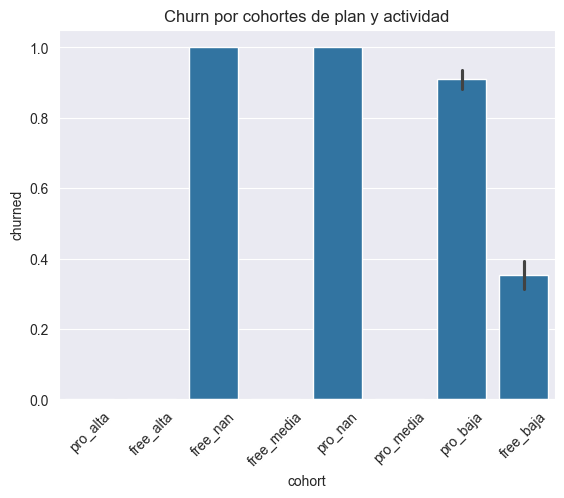

In [23]:
sns.barplot(data=df, x='cohort', y='churned')
plt.title('Churn por cohortes de plan y actividad')
plt.xticks(rotation=45)
plt.show()

**Pregunta:**
¿Las cohortes que combinan tipo de plan y nivel de actividad muestran patrones distintos de churn?

**Observación:**
Algunas cohortes como `free_nan` y `pro_nan` presentan valores extremos (churn = 1.0),
lo cual se debe a una cantidad muy baja de usuarios o a valores fuera de los rangos definidos
para el `activity_ratio`.

Entre las cohortes con muestra suficiente, se observa que:
- `pro_baja` presenta una tasa de churn muy alta (≈ 0.9)
- `free_baja` muestra una tasa de churn significativamente menor (≈ 0.3)

**Interpretación:**
Las cohortes con poca cantidad de usuarios no son confiables para extraer conclusiones.
Sin embargo, al analizar los grupos con suficiente muestra, se observa un patrón claro:
los usuarios pagos (Pro) con baja actividad tienen una mayor probabilidad de churn
en comparación con usuarios Free con el mismo nivel de actividad.

Esto sugiere que, en este dataset sintético, el churn no solo está relacionado con el uso,
sino también con las expectativas asociadas al tipo de plan.

In [26]:
corr = df[numeric_vars].corr()['churned'].sort_values(ascending=False)
corr.to_frame(name="correlación_con_churn")

,correlación_con_churn
churned,1.000000
tickets_per_session,0.224030
activity_ratio,-0.767828


### Correlación entre variables y churn

Se calculó la correlación de Pearson entre las variables numéricas y la variable objetivo (`churned`).

- `activity_ratio` presenta una correlación negativa fuerte con churn (-0.77),
  lo que indica que una mayor actividad reciente está asociada con una menor probabilidad de abandono.
- `tickets_per_session` muestra una correlación positiva moderada,
  sugiriendo que una mayor cantidad de tickets por sesión puede estar relacionada con fricción del usuario.

**Nota:**
La correlación indica asociación, no causalidad.
Estas métricas se utilizan para priorizar señales, no como prueba definitiva.


Este análisis se basa en un dataset simulado, por lo que los patrones observados
no deben interpretarse como conclusiones universales, sino como un ejercicio de análisis exploratorio.